# The hands-on workflow

The full development workflow we will follow is:

![workflow](https://github.com/neuromorphic-polito/inNuCE_BRANDY-2025/blob/main/images/workflow.png?raw=1)

In this notebook:
 - We will use **sinabs** to define and train our network
 - The network will be run using the sinabs "simulator" to obtain **sparsity** and **accuracy** metrics
 - The network will be deployed to **speck**, to obtain the **inference speed** as well. **NOTE:** For this step you need the hardware chip and you need to run the notebooks locally instead of on colab. If you want to try this out you can ask to the presenters for more information.
 - We will then do some basic analysis of how sparsity affects accuracy and speed.
 - Finally, we export the model to **NIR**.

This notebook has been adapted from https://sinabs.readthedocs.io/v3.0.3/tutorials/nmnist.html

See also https://www.youtube.com/watch?v=kOiyRtvPO2Q for more in-depth details of sinabs.  

# Package installation

Execute only if you are usng Goolge Colab. If you are using your own local environment make sure you installed the dependecies first


In [1]:
!pip install tonic
!pip install sinabs
!pip install torchmetrics
!pip install neurobench
!pip install snntorch
!pip install pandas
!pip install numpy --upgrade # make sure you have the last version of numpy, this could require to restart the session on Google Colab


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.1/126.1 kB 10.9 MB/s eta 0:00:00
  Created wheel for expelliarmus: filename=expelliarmus-1.1.12-cp312-cp312-linux_x86_64.whl size=56409 sha256=0081b3e7b950e60c6022bba40c5498e805bf2de6a1c7abfe33c6ca79293d428d
  Stored in directory: /root/.cache/pip/wheels/9a/9e/4b/f96da4dab397e63f90078766122e078e4ba82b2b48e07ee644
Successfully built expelliarmus
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
t

INFO: pip is looking at multiple versions of nirtorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 118.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tonic 1.6.0 requires numpy<2.0.0, but you have num

# Import packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchmetrics
import os
import sinabs
import sinabs.layers as sl
from tqdm import tqdm

from sinabs.hooks import register_synops_hooks

# Device setting

Set the availble device to train the model

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CUDA GPU


# Dataset Definition

We will use a simple dataset, the **neuromorphic N-MNIST** for demonstration purposes.

From https://www.garrickorchard.com/datasets/n-mnist:

> The Neuromorphic-MNIST (N-MNIST) dataset is a spiking version of the original frame-based MNIST dataset. It consists of the same 60 000 training and 10 000 testing samples as the original MNIST dataset, and is captured at the same visual scale as the original MNIST dataset (28x28 pixels). The N-MNIST dataset was captured by mounting the ATIS sensor on a motorized pan-tilt unit and having the sensor move while it views MNIST examples on an LCD monitor

We will get the data using the **tonic** library, which automatically handles the download ands extraction in case it does not exists.

From https://tonic.readthedocs.io/en/latest/index.html:

> Tonic provides publicly available event-based vision and audio datasets and event transformations. The package is fully compatible with PyTorch Vision / Audio to give you the flexibility that you need.

![mnistgif](images/nmnist.gif)

In [19]:
from tonic import datasets, transforms

def get_data_loaders(batch_size):

    transform = transforms.Compose([
        transforms.ToFrame(sensor_size=(34, 34, 2), n_time_bins=30, include_incomplete=True),  # Go from list of events to sparse frames
        lambda x: torch.from_numpy(x.astype(np.float32)),  # just to go from int to float, for compatibility with pytorch
    ])

    trainset = datasets.NMNIST('./data', train=True, transform=transform)
    testset = datasets.NMNIST('./data', train=False, transform=transform)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=0,
        drop_last=True, pin_memory=True
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, num_workers=0,
        drop_last=True, pin_memory=True
    )

    return trainloader, testloader

# Examine data

Lets get one single data point and plot the first frame (which will not show much), and the addition of 10 frames

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./data/NMNIST/test.zip to ./data/NMNIST
torch.Size([1, 30, 2, 34, 34])


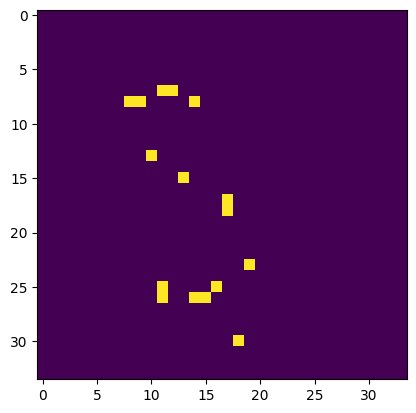

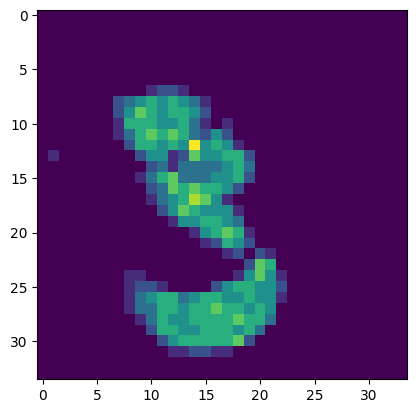

In [4]:
import matplotlib.pyplot as plt
tl, _ = get_data_loaders(1)
data, _ = next(iter(tl))
print(data.shape)
data = data[0] # remove batch dimension
plt.imshow(data[0, 0])  # one single frame, that can be used for SNN (as it has state)
plt.figure()
plt.imshow(data[:10, 0].sum(0)) # fist 10 frames added, for instance for a stateless ANN (normal convs)

# Model definition

Define a SNN model made of convolutional layers and **LIF** neurons.
As the task is relatively simple, and we want to keep training times reasonable for demonstration purposes, the model is simple as well.

Some considerations (this is very specific to Speck and probably not worth spending too much time on it):
 - **biases** are set to False to avoid running at fixed frequency on the chip: https://sinabs.readthedocs.io/v3.0.3/speck/notebooks/leak_neuron.html
 - The dimensions of our data are 5: **[batch, time, channels, height, width]**. Due to how speck works, the time needs to be flattened. This is because all the time steps are feed all at once instead of one by one. This means the first two dimensions (batch_size and time) are flattened together. In other words, the time dimension is treated as part of the batch size. This is done with the **FlattenTime()** class. The conv layers do not care about time, but the **IAF** layers do. That is why we use the **IAFSqueeze** version, that internally **unflattens** the time dimension and runs it one by one.

In [5]:
def create_model(batch_size):

    backend = sl
    min_v_mem = -1.  # cap the mem potential. Helpful when running on chip, to avoid quantization issues.

    model = nn.Sequential(
        sl.FlattenTime(),  # required by speck. Make the 5D input 4D, by treating the time as part of the batch size

        nn.Conv2d(2, 8, kernel_size=3, stride=2, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem), # Actual spiking layer.

        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),

        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),

        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),

        nn.Conv2d(64, 10, kernel_size=3, stride=1, padding=0, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),

        nn.Flatten(),
        sl.UnflattenTime(batch_size=batch_size),
    )
    return model


# ML workflow

![mlworkflow](images/ML-workflow.png)

# Evaluation

The following helper function just evaluates the model on a test set, using **cross entropy** between the prediction and the target

In [6]:
def evaluate_model(model, testloader, device):

    acc = torchmetrics.Accuracy('multiclass', num_classes=10).to(device)
    model.eval()

    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for data, targets in tqdm(testloader, desc="Evaluating"):
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            sinabs.reset_states(model)

            y_hat = model(data)
            pred = y_hat.sum(1)
            loss = nn.functional.cross_entropy(pred, targets)

            acc(pred, targets)
            total_loss += loss.item()
            num_batches += 1

    accuracy = acc.compute().item()
    avg_loss = total_loss / num_batches

    return accuracy, avg_loss

# Training Process with target synaptic operations

One of the main drivers of model performance (accuracy and speed), is the activation sparsity.

We control this with the **target_synops** parameter. This parameter is used together with the cross entropy between target and prediction, to calculate a loss that takes into account both accuracy and activity.

In [7]:
def train_and_evaluate(lr, batch_size, epochs, name, target_synops=False, max_iters=10000):

    learning_rate = lr
    batch_size = batch_size
    n_epochs = epochs

    acc = torchmetrics.Accuracy('multiclass', num_classes=10).to(device)

    # Create model and move to device
    model = create_model(batch_size)
    model = model.to(device)

    if target_synops:
        # Register synops hooks
        register_synops_hooks(model)

    # Create data loaders
    trainloader, testloader = get_data_loaders(batch_size)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Track best loss
    best_acc = 0

    for epoch in range(n_epochs):
        model.train()

        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{n_epochs}')

        sinabs.reset_states(model)
        sinabs.zero_grad(model)
        optimizer.zero_grad()

        iters = 0
        for data, targets in pbar:

            sinabs.reset_states(model)
            optimizer.zero_grad()

            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            output = model(data).sum(1)

            target_loss = nn.functional.cross_entropy(output, targets)
            if target_synops:
                synops = model.hook_data['total_synops_per_timestep']
                synops_loss = ((synops - target_synops) / target_synops) ** 2
                loss = 0.8 * target_loss + 0.2 * synops_loss
            else:
                loss = target_loss

            accuracy = acc(output, targets)
            loss.backward()
            optimizer.step()

            current_loss = loss.item()

            # Update progress bar
            pbar.set_postfix({
                'train_loss': f'{current_loss:.4f}',
                'train_acc': f'{accuracy.item():.2%}',
            })
            iters +=1
            if iters > max_iters:
                break

        # Evaluate on test set
        test_acc, test_loss = evaluate_model(model, testloader, device)

        pbar.set_postfix({
            'train_loss': f'{current_loss:.4f}',
            'train_acc': f'{accuracy:.2%}',
            'test_loss': f'{test_loss:.4f}',
            'test_acc': f'{test_acc:.4f}',
        })

        # Save best model
        if test_loss < best_loss:
            best_loss = test_loss
            best_acc = test_acc
            os.makedirs('saved_models', exist_ok=True)
            torch.save(model.cpu(), f'saved_models/{name}.pth')
            print(f"New best model saved with loss {best_loss:.4f} and {best_acc=}")
            model.to(device)

    print("\nTraining complete.")
    print(f"Final accuracy: {best_acc:.2%}")
    print(f"Final loss: {best_loss:.4f}")

    return {"accuracy": best_acc,
            "loss": best_loss}

### Train with no synops regulation

Lets first train without any synops regulation, to get an idea of the number of synaptic operations in the model when it is unconstrained.

**NOTE:** We are using only one epoch just for demo purposes. As the task is simple and the model is oversized for the task, one epoch is enough to get decent accuracy.

In [8]:
all_results: dict[dict] = {}

lr = 1e-3
batch_size = 32
epochs = 1

all_results['100'] = train_and_evaluate(lr, batch_size, epochs, '100', target_synops=False)


Evaluating: 100%|██████████| 312/312 [00:21<00:00, 14.20it/s]

New best model saved with loss 0.1074 and best_acc=0.9690504670143127

Training complete.
Final accuracy: 96.91%
Final loss: 0.1074


# Model statistics on Simulation

We can use sinabs **hooks** in order to collect data the synaptic operations performed when simulating. We define the following helper functions:

In [9]:
import sinabs.layers as sl

from sinabs.hooks import register_synops_hooks, firing_rate_hook, get_hook_data_dict

def record_output_hook(module, input, output):
    data = get_hook_data_dict(module)
    data["output"] = output

def register_hooks(model):
    register_synops_hooks(model)
    for layer in model:
        if isinstance(layer, sl.StatefulLayer) and layer.does_spike:
            layer.register_forward_hook(firing_rate_hook)
            layer.register_forward_hook(record_output_hook)

def sinabs_total_syn_ops(model):

    return model.hook_data['total_synops_per_timestep'].item()

def sinabs_syn_ops_by_layer(model):

    counts = [x.item() for x in model.hook_data['synops_per_timestep'].values()]
    return counts

def sinabs_firing_rate_by_layer(model):

    rates = []
    for layer in model:
        if isinstance(layer, sl.StatefulLayer) and layer.does_spike:
            rates.append(layer.hook_data['firing_rate'].item())

    return rates

def activation_sparsity(model):
    total_spike_num = 0  # Count of non-zero activations
    total_neuro_num = 0  # Count of all activations

    sparsity_by_layer = []

    for layer in model:
            if isinstance(layer, sl.StatefulLayer) and layer.does_spike:
                total_spike_num += layer.hook_data['output'].gt(0).sum().item()
                total_neuro_num += layer.hook_data['output'].numel()

                sparsity_by_layer.append((layer.hook_data['output'].numel() - layer.hook_data['output'].gt(0).sum().item())/layer.hook_data['output'].numel())

    sparsity = (total_neuro_num - total_spike_num) / total_neuro_num
    return sparsity, sparsity_by_layer

def run_and_get_statistics(model_path):

    _, testloader = get_data_loaders(32)
     # Load model
    model = torch.load(model_path, weights_only=False)
    model = model.to(device)
    register_hooks(model)

    # Initialize accumulators
    total_syn_ops = 0
    total_samples = 0
    synops_by_layer_accum = None
    firing_rate_by_layer_accum = None
    total_act_sparsity = 0
    act_sparsity_by_layer_accum = None

    # Loop through entire dataset
    for batch, _ in testloader:
        batch = batch.to(device)  # Send to device
        sinabs.reset_states(model)

        # Forward pass
        model(batch)

        # Collect metrics
        synops = sinabs_total_syn_ops(model)
        synops_by_layer = sinabs_syn_ops_by_layer(model)
        firing_rate_by_layer = sinabs_firing_rate_by_layer(model)
        act_sparsity, act_sparsity_by_layer = activation_sparsity(model)

        # Aggregate metrics
        batch_size = batch.size(0)
        total_syn_ops += synops * batch_size
        total_act_sparsity += act_sparsity * batch_size
        total_samples += batch_size

        if synops_by_layer_accum is None:
            synops_by_layer_accum = [v * batch_size for v in synops_by_layer]
            firing_rate_by_layer_accum = [v * batch_size for v in firing_rate_by_layer]
            act_sparsity_by_layer_accum = [v * batch_size for v in act_sparsity_by_layer]
        else:
            for i in range(len(synops_by_layer_accum)):
                synops_by_layer_accum[i] += synops_by_layer[i] * batch_size
                firing_rate_by_layer_accum[i] += firing_rate_by_layer[i] * batch_size
                act_sparsity_by_layer_accum[i] += act_sparsity_by_layer[i] * batch_size

    # Compute averages
    synops_by_layer_avg = [v / total_samples for v in synops_by_layer_accum]
    firing_rate_by_layer_avg = [v / total_samples for v in firing_rate_by_layer_accum]
    act_sparsity_by_layer_avg = [v / total_samples for v in act_sparsity_by_layer_accum]
    total_act_sparsity_avg = total_act_sparsity / total_samples
    total_syn_ops_avg = total_syn_ops / total_samples

    return {
        "total_synops": total_syn_ops_avg,
        "synops_per_layer": synops_by_layer_avg,
        "fire_rate_per_layer": firing_rate_by_layer_avg,
        "total_act_sparsity": total_act_sparsity_avg,
        "act_sparsity_per_layer": act_sparsity_by_layer_avg
        }


In [10]:
all_results['100'].update(run_and_get_statistics("./saved_models/100.pth"))


# Train models with target synaptic operations

Now that we know what are the "maximum" synaptic operations, lets define other models with lower synops target

In [11]:
max_synops = all_results['100']['total_synops']
print(max_synops)

36806.962311573516


In [12]:
syn_to_keep = 0.7
target_synops = int(max_synops*syn_to_keep)
name = str(int(syn_to_keep*100))
all_results[name] = train_and_evaluate(lr, batch_size, epochs, name, target_synops=target_synops)


Evaluating: 100%|██████████| 312/312 [00:21<00:00, 14.29it/s]

New best model saved with loss 0.0904 and best_acc=0.9694511294364929

Training complete.
Final accuracy: 96.95%
Final loss: 0.0904


In [13]:
syn_to_keep = 0.5
target_synops = int(max_synops*syn_to_keep)
name = str(int(syn_to_keep*100))
all_results[name] = train_and_evaluate(lr, batch_size, epochs, name, target_synops=target_synops)

Evaluating: 100%|██████████| 312/312 [00:21<00:00, 14.82it/s]

New best model saved with loss 0.1188 and best_acc=0.9594351053237915

Training complete.
Final accuracy: 95.94%
Final loss: 0.1188


In [14]:
syn_to_keep = 0.1
target_synops = int(max_synops*syn_to_keep)
name = str(int(syn_to_keep*100))
all_results[name] = train_and_evaluate(lr, batch_size, epochs, name, target_synops=target_synops)

Evaluating: 100%|██████████| 312/312 [00:23<00:00, 13.18it/s]

New best model saved with loss 0.1200 and best_acc=0.9609375

Training complete.
Final accuracy: 96.09%
Final loss: 0.1200


In [15]:
syn_to_keep = 0.05
target_synops = int(max_synops*syn_to_keep)
name = str(int(syn_to_keep*100))
all_results[name] = train_and_evaluate(lr, batch_size, epochs, name, target_synops=target_synops)

Evaluating: 100%|██████████| 312/312 [00:21<00:00, 14.38it/s]

New best model saved with loss 0.5429 and best_acc=0.8186097741127014

Training complete.
Final accuracy: 81.86%
Final loss: 0.5429


In [43]:
syn_to_keep = 0.049
target_synops = int(max_synops*syn_to_keep)
name = str(int(syn_to_keep*100))
all_results[name] = train_and_evaluate(lr, batch_size, epochs, name, target_synops=target_synops)

Evaluating: 100%|██████████| 312/312 [00:22<00:00, 14.13it/s]


New best model saved with loss 0.3605 and best_acc=0.8771033883094788

Training complete.
Final accuracy: 87.71%
Final loss: 0.3605


In [16]:
syn_to_keep = 0.03
target_synops = int(max_synops*syn_to_keep)
name = str(int(syn_to_keep*100))
all_results[name] = train_and_evaluate(lr, batch_size, epochs, name, target_synops=target_synops)

Evaluating: 100%|██████████| 312/312 [00:21<00:00, 14.38it/s]

New best model saved with loss 2.3026 and best_acc=0.09815704822540283

Training complete.
Final accuracy: 9.82%
Final loss: 2.3026


In [17]:
syn_to_keep = 0.01
target_synops = int(max_synops*syn_to_keep)
name = str(int(syn_to_keep*100))
all_results[name] = train_and_evaluate(lr, batch_size, epochs, name, target_synops=target_synops)

Evaluating: 100%|██████████| 312/312 [00:21<00:00, 14.56it/s]


New best model saved with loss 2.3026 and best_acc=0.09815704822540283

Training complete.
Final accuracy: 9.82%
Final loss: 2.3026


# Compare all models

Lets now compare all models in terms of accuracy, synops and sparsity

In [44]:
import os

for path in os.listdir("./saved_models/"):
    if not path.endswith(".pth"):
        continue
    if '100' in path:
        continue

    all_results[path.removesuffix(".pth")].update(run_and_get_statistics(f"./saved_models/{path}"))

Save and load results to avoid re-running training and statistics

In [45]:
import json
import os

os.makedirs('saved_models', exist_ok=True)
with open('saved_models/all_results.json', 'w') as f:
    json.dump(all_results, f, indent=4)

In [20]:
import json

with open('saved_models/all_results.json', 'r') as f:
    all_results = json.load(f)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame
df = pd.DataFrame(all_results)
df = df.T.reset_index().rename(columns={'index': 'model'})
df['model'] = df['model'].apply(int)
df.sort_values("model", inplace=True)

display(df)

,model,accuracy,loss,total_synops,synops_per_layer,fire_rate_per_layer,total_act_sparsity,act_sparsity_per_layer
6,1,0.098157,2.302585,4961.694532,"[2522.347073286008, 865.2683181762695, 1574.07...","[0.01027015646179326, 0.016468121076169878, 0....",0.994218,"[0.9924733437398342, 0.9911450141213587, 1.0, ..."
5,3,0.098157,2.302585,5881.479243,"[2522.347073286008, 1171.9148600651667, 2187.2...","[0.013970506147672541, 0.023510559205300152, 0...",0.993596,"[0.9914175079204005, 0.9906319633017767, 1.0, ..."
7,4,0.877103,0.360542,7083.64198,"[2522.347073286008, 2303.487991724259, 1758.21...","[0.027590441189180963, 0.018810652581473384, 0...",0.988996,"[0.9853491610221108, 0.9900751593496093, 0.996..."
4,5,0.81861,0.542907,6916.333153,"[2522.347073286008, 2405.1207400590947, 1523.2...","[0.028837264607994795, 0.016188816168906692, 0...",0.986726,"[0.9809995156032815, 0.9904344044091951, 0.997..."
3,10,0.960938,0.120013,6371.237338,"[2522.347073286008, 1515.0562231601814, 1362.9...","[0.018187863871646233, 0.01468609028066007, 0....",0.987801,"[0.9865657904434866, 0.9881905982699893, 0.993..."
2,50,0.959435,0.118798,20410.376024,"[2522.347073286008, 5944.649029071515, 6799.48...","[0.07125570721781024, 0.07310174384082739, 0.0...",0.959524,"[0.9529439649575414, 0.9568221319749458, 0.969..."
1,70,0.969451,0.090397,26825.867391,"[2522.347073286008, 7831.907237517528, 10085.6...","[0.09402579005855398, 0.10795394264352627, 0.0...",0.94689,"[0.9372388974030877, 0.9385662507542938, 0.966..."
0,100,0.96905,0.107447,36806.962312,"[2522.347073286008, 9544.976960011018, 14626.1...","[0.11456179411078875, 0.15714161902761611, 0.0...",0.941571,"[0.9362075933373438, 0.9292758768968619, 0.953..."


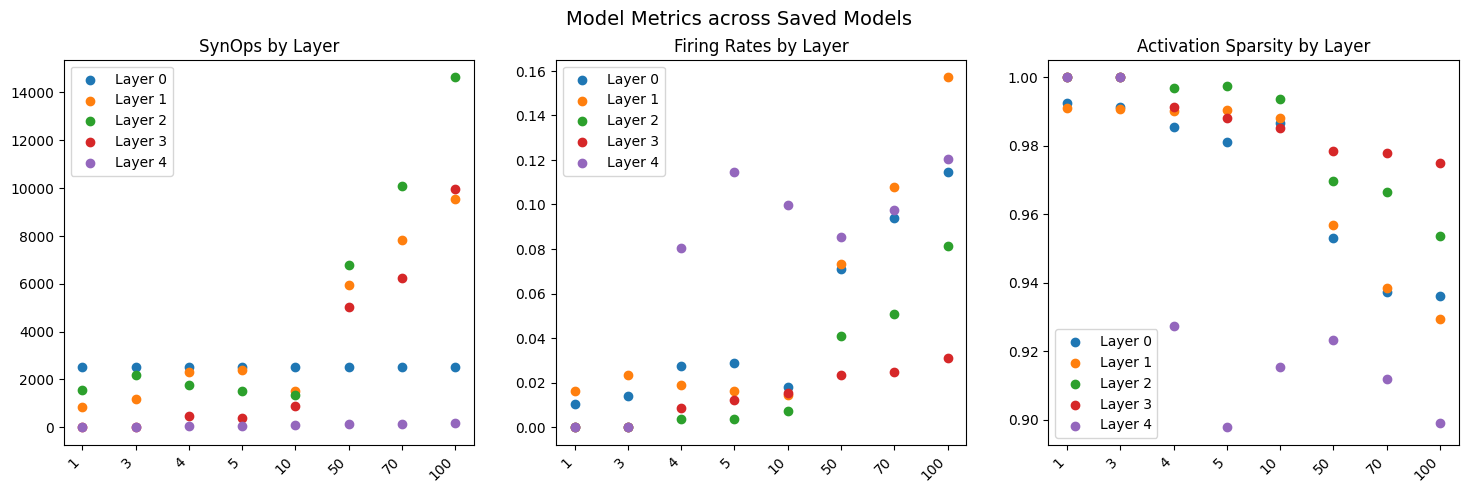

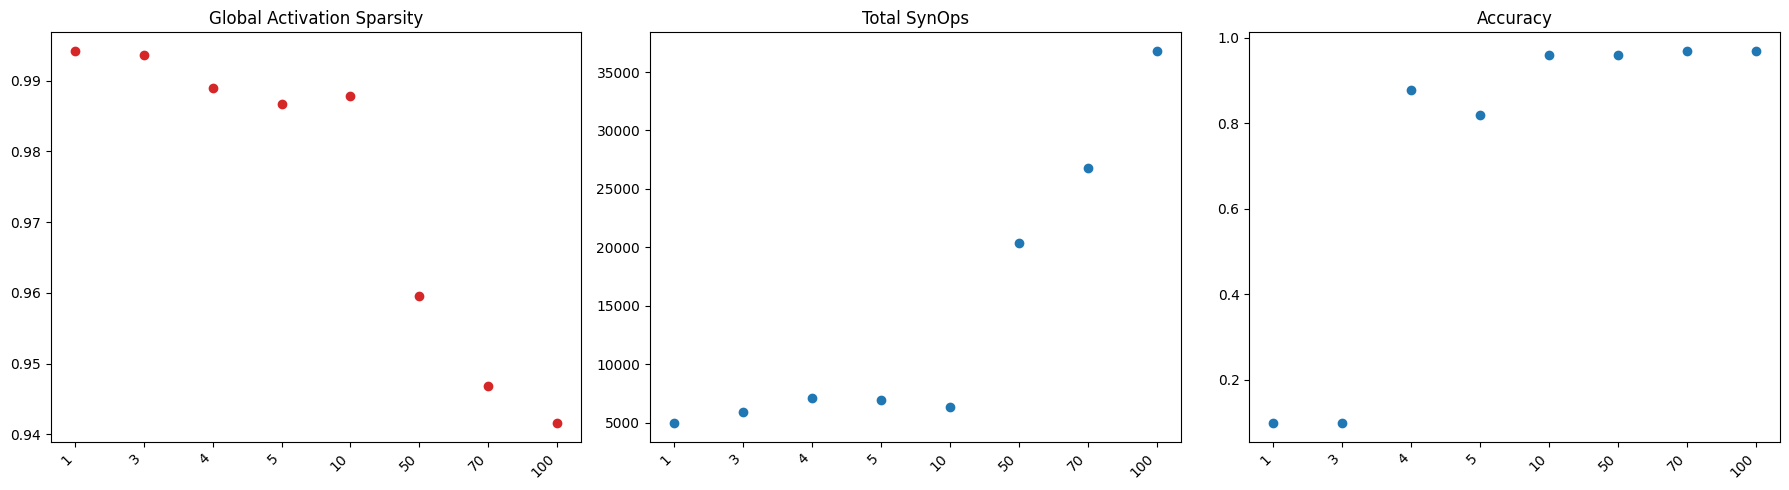

In [52]:

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Model Metrics across Saved Models", fontsize=14)

x_positions = np.arange(len(df["model"]))  # numeric positions for scatter
x_labels = df["model"]

# Scatter SynOps by Layer
for i, layer in enumerate(np.stack(df['synops_per_layer'].to_numpy()).T):
    axs[0].scatter(x_positions, layer, label=f"Layer {i}")
axs[0].set_title("SynOps by Layer")
axs[0].set_xticks(x_positions)
axs[0].set_xticklabels(x_labels, rotation=45, ha='right')
axs[0].legend()

# Scatter Firing Rate by Layer
for i, layer in enumerate(np.stack(df['fire_rate_per_layer'].to_numpy()).T):
    axs[1].scatter(x_positions, layer, label=f"Layer {i}")
axs[1].set_title("Firing Rates by Layer")
axs[1].set_xticks(x_positions)
axs[1].set_xticklabels(x_labels, rotation=45, ha='right')
axs[1].legend()

# Scatter Activation Sparsity by Layer
for i, layer in enumerate(np.stack(df['act_sparsity_per_layer'].to_numpy()).T):
    axs[2].scatter(x_positions, layer, label=f"Layer {i}")
axs[2].set_title("Activation Sparsity by Layer")
axs[2].set_xticks(x_positions)
axs[2].set_xticklabels(x_labels, rotation=45, ha='right')
axs[2].legend()


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

x_positions = np.arange(len(df["model"]))  # numeric positions for scatter
x_labels = df["model"]

# Scatter Global Activation Sparsity
axs[0].scatter(x_positions, df['total_act_sparsity'], color='tab:red')
axs[0].set_title("Global Activation Sparsity")
axs[0].set_xticks(x_positions)
axs[0].set_xticklabels(x_labels, rotation=45, ha='right')

# Scatter total SynOps
axs[1].scatter(x_positions, df['total_synops'], color='tab:blue')
axs[1].set_title("Total SynOps")
axs[1].set_xticks(x_positions)
axs[1].set_xticklabels(x_labels, rotation=45, ha='right')

# Scatter accuracy
axs[2].scatter(x_positions, df['accuracy'], color='tab:blue', )
axs[2].set_title("Accuracy")
axs[2].set_xticks(x_positions)
axs[2].set_xticklabels(x_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Model deployment on Speck

Deployment on Speck is performed using the samna package, and the sinabs backend specific to our target, in our case the **DynapcnnNetwork** that is at the core of Speck.

Notice that because the model was trained with floating point arithmetic, we need to quantize it (discretize it). This can affect heavily the performance of the model, and it is done by sinabs automagically. Another (usually better) option is to use quantized aware training.

In this demo we are not focusing on quantization and its effects on accuracy, but rather on inference speed.

![quant](images/quantization.png)

In [ ]:
import time
import torch
import numpy as np
import pandas as pd
from collections import defaultdict

import samna
from sinabs.backend.dynapcnn import DynapcnnNetwork
from sinabs.backend.dynapcnn.chip_factory import ChipFactory
from sinabs.backend.dynapcnn.dynapcnn_visualizer import DynapcnnVisualizer
from tonic import datasets, transforms
import os
import pandas as pd


transform = transforms.Compose([
        transforms.ToFrame(sensor_size=(34, 34, 2), n_time_bins=30, include_incomplete=True),
        lambda x: torch.from_numpy(x.astype(np.float32)),
    ])

def run_hw(model_path, monitor_layers='all'):

    testset = datasets.NMNIST('./data', train=False, transform=transform)
    class_samples = {i: [] for i in range(10)}  # Dictionary to store samples for each class

    for data, label in testset:
        if len(class_samples[label]) < 10:
            class_samples[label].append(data)
        if all(len(samples) == 10 for samples in class_samples.values()):
            break

    data = torch.stack([torch.stack(samples) for samples in class_samples.values()]).numpy()
    data = data.reshape(-1, 30, 2, 34, 34)  # Reshape to [batch_size, time_bins, channels, height, width]


    devices = samna.device.get_unopened_devices()
    speck = samna.device.open_device(devices[0])
    device_id = 'speck2fdevkit'

    try:

        cnn = torch.load(model_path, weights_only=False, map_location='cpu')

        print("Initialized SpeckModel.")

        data_shape = [100] + [30,2,34,34]

        print(f"Data prepared with shape: {data_shape}")


        # Notice the discretize option. As the model was trained in floating point, we need to convert it to a fixed range representation
        dynapcnn_model = DynapcnnNetwork(cnn[0:-1], input_shape=[2, 34, 34], dvs_input=False, discretize=True)
        print("Initialized DynapcnnNetwork.")
        dynapcnn_model.to(device_id, chip_layers_ordering="auto", monitor_layers='all', slow_clk_frequency=None)
        print("Model transferred to device.")
        layer_in = dynapcnn_model.chip_layers_ordering[0]


        chip_factory = ChipFactory(device_id)
        data = [chip_factory.raster_to_events(torch.from_numpy(x), layer=layer_in, dt=1/(data_shape[1]-1)) for x in data]
        print("Data converted to events.")

        pwr_mon = speck.get_power_monitor()
        source = pwr_mon.get_source_node()
        sink = samna.graph.sink_from(source)
        pwr_mon.start_auto_power_measurement(100.0)


        total_spike_num = 0
        total_neuro_num = 0
        layer_neuro_num = defaultdict(int)
        layer_spike_num = defaultdict(int)
        layer_sparsity = defaultdict(float)
        layer_outputs = defaultdict(list)

        start_ts = time.time()
        for sample in data:
            output_events = dynapcnn_model(sample)

            if monitor_layers is None:
                continue

            for id, layer in enumerate(dynapcnn_model.chip_layers_ordering):

                output_events_layer = [each for each in output_events if each.layer == layer]

                if len(output_events_layer) == 0:
                    layer_neuro_num[id] += 0
                    layer_spike_num[id] += 0
                    continue
                layer_outputs[id].append(output_events_layer)

        end_ts = time.time()
        print(f"Processed all data samples in {end_ts - start_ts} seconds.")

        pwr_mon.stop_auto_power_measurement()
        powers = pd.DataFrame([(x.channel, x.value) for x in sink.get_events()], columns=["ch", "pwr"])

    finally:

        samna.device.close_device(speck)
        print("Closed device.")

        powers = powers.groupby('ch').mean()['pwr'].to_list()
        fps = len(data) / (end_ts - start_ts)
        print(f"FPS: {fps}")

        dt= 1 / (data_shape[1] - 1)

        for layer in layer_outputs.keys():
            for i in range(len(layer_outputs[layer])):
                layer_n_spks = chip_factory.events_to_raster(layer_outputs[layer][i], dt=dt)

                tot_neurons = layer_n_spks.numel()
                tot_spikes = layer_n_spks.gt(0.0).sum().item()

                layer_neuro_num[layer] += tot_neurons
                layer_spike_num[layer] += tot_spikes

                total_spike_num += tot_spikes
                total_neuro_num += tot_neurons


        for key in layer_neuro_num:
                sparsity = (
                    (layer_neuro_num[key] - layer_spike_num[key])
                    / layer_neuro_num[key]
                    if layer_neuro_num[key] != 0
                    else 0.0
                )
                layer_sparsity[key] = sparsity

        activation_sparsity = ((total_neuro_num - total_spike_num) / total_neuro_num) if total_neuro_num != 0 else 0.0

        print(f"Total spikes: {total_spike_num}")
        print(f"Total neurons: {total_neuro_num}")
        print(f"Tot. Dynamic Power: {(powers[1]+ powers[2])*1e3} mW")

        print(f"Activation sparsity: {activation_sparsity}")

        return {
            'powers': powers,
            'fps': fps,
            'act_sparsity': activation_sparsity,
            'act_sp_by_layer': dict(layer_sparsity),
            'tot_spikes': total_spike_num
        }


In [23]:
model_files = [f for f in os.listdir("./saved_models/") if f.endswith('.pth')]
for model_file in model_files:
    model_path = os.path.join("./saved_models", model_file)

    print("Starting main execution.")
    print(f"Model name: {model_file}")
    power, fps, act_sparsity, act_sp_by_layer, tot_spikes = run_hw(model_path)
    print(f"Results completed for model {model_file}")

    all_results[model_file.removesuffix(".pth")].update(run_hw(model_path))

Starting main execution.
Model name: 70.pth
Initialized SpeckModel.
Data prepared with shape: [100, 30, 2, 34, 34]
Initialized DynapcnnNetwork.
Network is valid
Model transferred to device.
Data converted to events.
Processed all data samples in 122.62232184410095 seconds.
Closed device.
FPS: 0.8155122044348302
Total spikes: 850981
Total neurons: 14313563
Tot. Dynamic Power: 0.6023538906220873 mW
Activation sparsity: 0.9405472278285987
Results completed for model 70.pth
Initialized SpeckModel.
Data prepared with shape: [100, 30, 2, 34, 34]
Initialized DynapcnnNetwork.
Network is valid
Model transferred to device.
Data converted to events.
Processed all data samples in 122.63432121276855 seconds.
Closed device.
FPS: 0.815432409223366
Total spikes: 851211
Total neurons: 14304937
Tot. Dynamic Power: 0.6150761433429611 mW
Activation sparsity: 0.9404952989307118
Starting main execution.
Model name: 3.pth
Initialized SpeckModel.
Data prepared with shape: [100, 30, 2, 34, 34]
Initialized Dyna

In [29]:
import json
import os

os.makedirs('saved_models', exist_ok=True)
with open('saved_models/all_results.json', 'w') as f:
    json.dump(all_results, f, indent=4)

In [ ]:
import json

with open('saved_models/all_results.json', 'r') as f:
    all_results = json.load(f)

In [27]:
# Convert to DataFrame
df = pd.DataFrame(all_results)
df = df.T.reset_index().rename(columns={'index': 'model'})
df['model'] = df['model'].apply(int)
df.sort_values("model", inplace=True)

display(df)

,model,accuracy,loss,total_synops,synops_per_layer,fire_rate_per_layer,total_act_sparsity,act_sparsity_per_layer,powers,fps,act_sparsity,act_sp_by_layer,tot_spikes
6,1,0.098157,2.302585,4961.694532,"[2522.347073286008, 865.2683181762695, 1574.07...","[0.01027015646179326, 0.016468121076169878, 0....",0.994218,"[0.9924733437398342, 0.9911450141213587, 1.0, ...","[4.821981264793224e-05, 0.00010015116616881171...",0.825982,0.981455,"{2: 0.0, 3: 0.0, 4: 0.0, 0: 0.9808480280531211...",184967
5,3,0.098157,2.302585,5881.479243,"[2522.347073286008, 1171.9148600651667, 2187.2...","[0.013970506147672541, 0.023510559205300152, 0...",0.993596,"[0.9914175079204005, 0.9906319633017767, 1.0, ...","[4.7693268665906666e-05, 9.461079964919775e-05...",0.82763,0.976614,"{2: 0.0, 3: 0.0, 4: 0.0, 0: 0.9748265830755254...",159607
7,4,0.877103,0.360542,7083.64198,"[2522.347073286008, 2303.487991724259, 1758.21...","[0.027590441189180963, 0.018810652581473384, 0...",0.988996,"[0.9853491610221108, 0.9900751593496093, 0.996...","[4.680929383744346e-05, 8.95118228301065e-05, ...",0.827963,0.983786,"{0: 0.979414648764343, 1: 0.9841044930292863, ...",195933
4,5,0.81861,0.542907,6916.333153,"[2522.347073286008, 2405.1207400590947, 1523.2...","[0.028837264607994795, 0.016188816168906692, 0...",0.986726,"[0.9809995156032815, 0.9904344044091951, 0.997...","[4.7096167803698885e-05, 8.971853961051057e-05...",0.82781,0.976075,"{0: 0.9710628753170377, 1: 0.9833597975807805,...",241921
3,10,0.960938,0.120013,6371.237338,"[2522.347073286008, 1515.0562231601814, 1362.9...","[0.018187863871646233, 0.01468609028066007, 0....",0.987801,"[0.9865657904434866, 0.9881905982699893, 0.993...","[4.663982192049138e-05, 8.616985965249063e-05,...",0.829316,0.985875,"{0: 0.9851409026365514, 1: 0.9862346759267743,...",191154
2,50,0.959435,0.118798,20410.376024,"[2522.347073286008, 5944.649029071515, 6799.48...","[0.07125570721781024, 0.07310174384082739, 0.0...",0.959524,"[0.9529439649575414, 0.9568221319749458, 0.969...","[5.0507712000646554e-05, 0.0001353992309098534...",0.819778,0.954353,"{0: 0.948097694156572, 1: 0.9499360693017618, ...",647328
1,70,0.969451,0.090397,26825.867391,"[2522.347073286008, 7831.907237517528, 10085.6...","[0.09402579005855398, 0.10795394264352627, 0.0...",0.94689,"[0.9372388974030877, 0.9385662507542938, 0.966...","[5.3239145024627876e-05, 0.0001605499705214436...",0.815432,0.940495,"{0: 0.931526913985885, 1: 0.9288738926162862, ...",851211
0,100,0.96905,0.107447,36806.962312,"[2522.347073286008, 9544.976960011018, 14626.1...","[0.11456179411078875, 0.15714161902761611, 0.0...",0.941571,"[0.9362075933373438, 0.9292758768968619, 0.953...","[5.472155205101062e-05, 0.00018688909902293352...",0.80993,0.935165,"{0: 0.9308963921928002, 1: 0.9191738406209415,...",926923


# Model statistics on Hardware

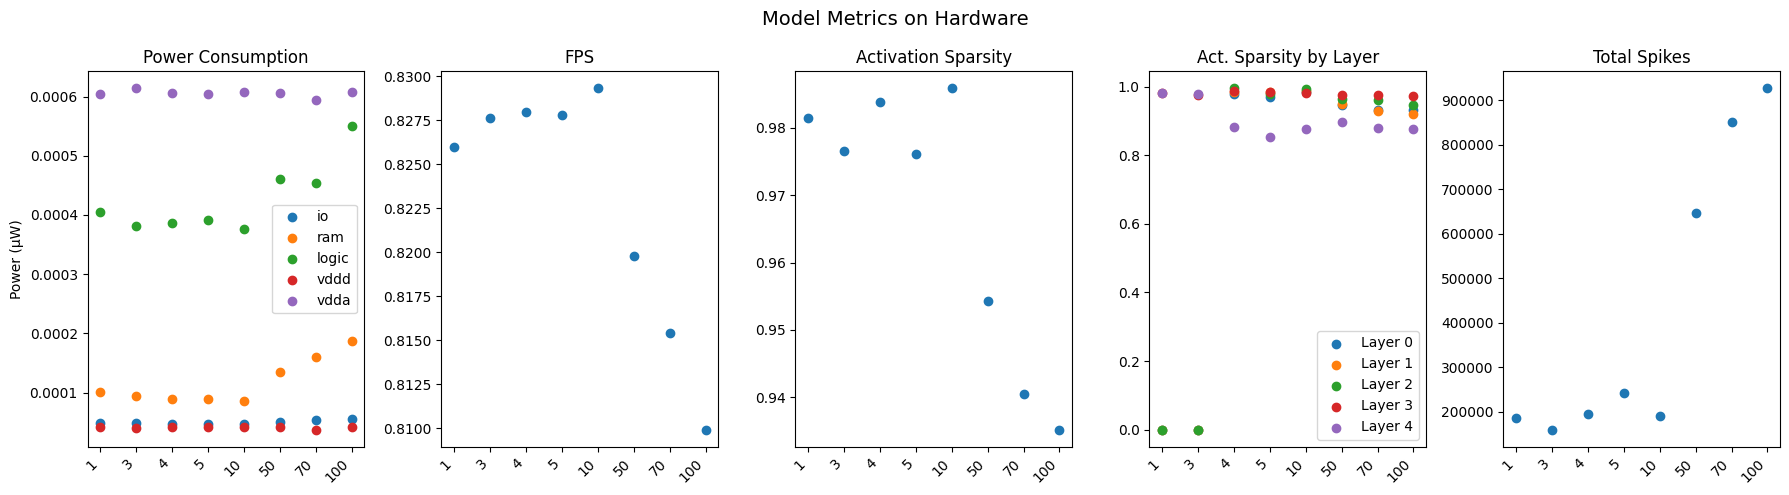

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pwr_chan_label = ["io", "ram", "logic", "vddd", "vdda"]

# Sort by model name (optional)
df.sort_values("model", inplace=True)

# Create x-axis positions
x_positions = np.arange(len(df["model"]))
x_labels = df["model"]

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 5))
fig.suptitle("Model Metrics on Hardware", fontsize=14)


for i, ch in enumerate(np.stack(df['powers'].to_numpy()).T):
    axs[0].scatter(x_positions, ch, label=f"{pwr_chan_label[i]}")
axs[0].set_title("Power Consumption")
axs[0].set_ylabel("Power (µW)")
axs[0].set_xticks(x_positions)
axs[0].set_xticklabels(x_labels, rotation=45, ha="right")
axs[0].legend()

axs[1].scatter(x_positions, df['fps'])
axs[1].set_title("FPS")
axs[1].set_xticks(x_positions)
axs[1].set_xticklabels(x_labels, rotation=45, ha="right")

axs[2].scatter(x_positions, df['act_sparsity'])
axs[2].set_title("Activation Sparsity")
axs[2].set_xticks(x_positions)
axs[2].set_xticklabels(x_labels, rotation=45, ha="right")

layer_sparsities = np.stack(df['act_sp_by_layer'].to_numpy()).T
sparsity_vectors = np.array([list(d.values()) for d in layer_sparsities])

for i in range(sparsity_vectors.shape[1]):
    axs[3].scatter(x_positions, sparsity_vectors[:, i], label=f"Layer {i}")
axs[3].set_title("Act. Sparsity by Layer")
axs[3].set_xticks(x_positions)
axs[3].set_xticklabels(x_labels, rotation=45, ha="right")
axs[3].legend()

axs[4].scatter(x_positions, df['tot_spikes'])
axs[4].set_title("Total Spikes")
axs[4].set_xticks(x_positions)
axs[4].set_xticklabels(x_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()

# How to choose the correct sparsity inducing approach?

Choosing the correct sparsity inducing approach is not easy, as we need to keep in mind some considerations:

 - In neuromorphic hardware have different computational units ("neuron cores") that run in parallel, and each of them executes a subset of your network (for example a single layer)
 - These neuron cores communicate with each other using efficient event based communication
 - The hardware is able to exploit unstructured sparsity: Just pruning a few values in the synaptic weight matrix, or reducing the amount of events coming out from one of the layers will reduce computational time
 - Although neuron cores  run in parallel they still need to synchronize, therefore the **slowest neuron core** in the network will slow down everything
 - Each hardware has different characteristics and limitations regarding the support for sparsity, for example Loihi 2 does not support well weight sparsity for convolutional layers
  - Each hardware is different and the bottleneck can vary. It could be memory access, spike transmission, neuron model computation, etc.
  - An oversized network with high sparsity can perform better than a small network with low sparsity:

Therefore
 - You need to choose the sparsity levels so that you are actually getting runtime (and therefore energy) improvements. For example, tunning sparsity layer-by-layer, to speed up the slowest core.

# NIR

Finally we export the model using the Neuromorphic Intermediate Representation package

In [30]:
from sinabs.nir import to_nir
import nir

model = create_model(batch_size=1)
model = model[1:-1]  # We dont need the flatten/unflatten layers as they are specific to speck

os.makedirs('exported_models', exist_ok=True)

model_files = [f for f in os.listdir("./saved_models/") if f.endswith('.pth')]
for model_file in model_files:
    model_path = os.path.join("./saved_models", model_file)

    checkpoint = torch.load(model_path, weights_only=False, map_location='cpu')
    filtered_state_dict = {
        k: v for k, v in checkpoint.state_dict().items() if "v_mem" not in k
    }

    model.load_state_dict(filtered_state_dict, strict=False)

    nir_graph = to_nir(model, sample_data=torch.rand((1, 2, 34, 34)))
    nir_graph.infer_types()
    nir_model_name = model_file.replace('.pth', '.nir')
    nir.write(f"exported_models/{nir_model_name}", nir_graph)

[warning] 1.input_type undefined, set to input.output_type
[warning] 3.input_type undefined, set to 2.output_type
[warning] 5.input_type undefined, set to 4.output_type
[warning] 7.input_type undefined, set to 6.output_type
[warning] 9.input_type undefined, set to 8.output_type
[warning] 11.input_type undefined, set to 10.output_type
updateing flatten output
[warning] 1.input_type undefined, set to input.output_type
[warning] 3.input_type undefined, set to 2.output_type
[warning] 5.input_type undefined, set to 4.output_type
[warning] 7.input_type undefined, set to 6.output_type
[warning] 9.input_type undefined, set to 8.output_type
[warning] 11.input_type undefined, set to 10.output_type
updateing flatten output
[warning] 1.input_type undefined, set to input.output_type
[warning] 3.input_type undefined, set to 2.output_type
[warning] 5.input_type undefined, set to 4.output_type
[warning] 7.input_type undefined, set to 6.output_type
[warning] 9.input_type undefined, set to 8.output_type